In [11]:
# EMPLOYEE ATTRITION PREDICTOR — Clean Runnable Notebook


In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap

np.random.seed(42)
print("Libraries loaded")


Libraries loaded


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

# LOAD DATASET (change path if needed)
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [15]:

print("Dataset shape:", df.shape)

drop_cols = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})
df.head()


Dataset shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [16]:

le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,2,0,...,3,1,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,3,1,...,4,4,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,4,1,...,3,2,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,4,0,...,3,3,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,1,...,3,4,1,6,3,3,2,2,2,2


In [17]:

X = df.drop("Attrition", axis=1)
y = df["Attrition"]
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Split complete")


Split complete


In [18]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done")


Scaling done


In [19]:

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

model.fit(X_train_scaled, y_train)
print("Model trained")


Model trained


Accuracy: 0.8299319727891157
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.36      0.09      0.14        47

    accuracy                           0.83       294
   macro avg       0.61      0.53      0.52       294
weighted avg       0.77      0.83      0.78       294



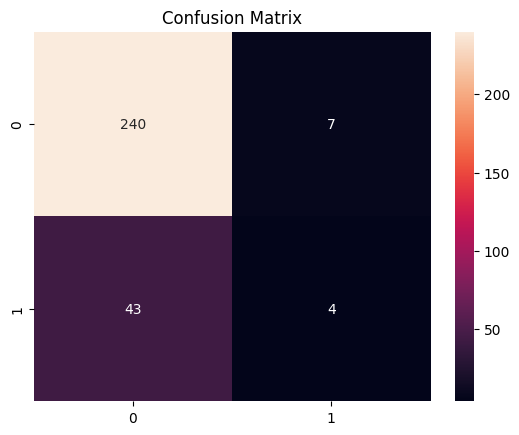

In [20]:

preds = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [21]:

probabilities = model.predict_proba(X_test_scaled)[:, 1]

def risk_zone(p):
    if p < 0.2: return "Very Low"
    if p < 0.4: return "Low"
    if p < 0.6: return "Medium"
    if p < 0.8: return "High"
    return "Very High"

risk_labels = [risk_zone(p) for p in probabilities]
pd.Series(risk_labels).value_counts()


,count
Very Low,212
Low,61
Medium,17
Very High,2
High,2


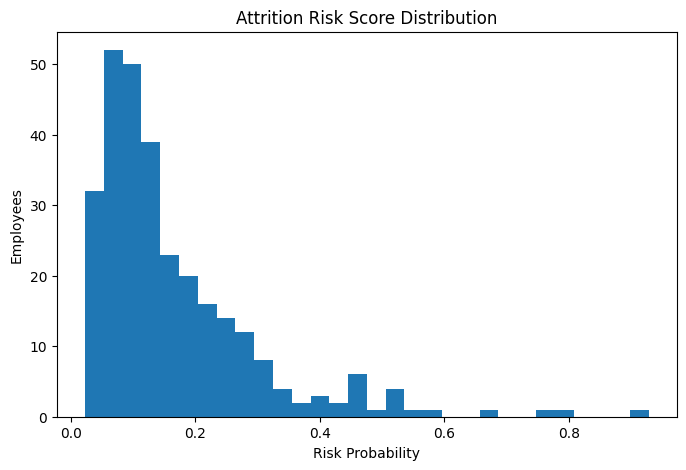

In [22]:

plt.figure(figsize=(8,5))
plt.hist(probabilities, bins=30)
plt.title("Attrition Risk Score Distribution")
plt.xlabel("Risk Probability")
plt.ylabel("Employees")
plt.show()


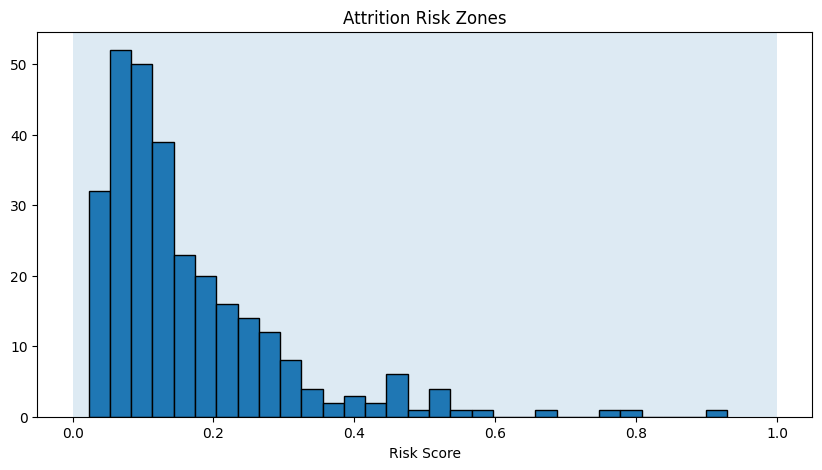

In [23]:

plt.figure(figsize=(10,5))

bounds = [0, .2, .4, .6, .8, 1]
for i in range(5):
    plt.axvspan(bounds[i], bounds[i+1], alpha=0.15)

plt.hist(probabilities, bins=30, edgecolor="black")
plt.title("Attrition Risk Zones")
plt.xlabel("Risk Score")
plt.show()


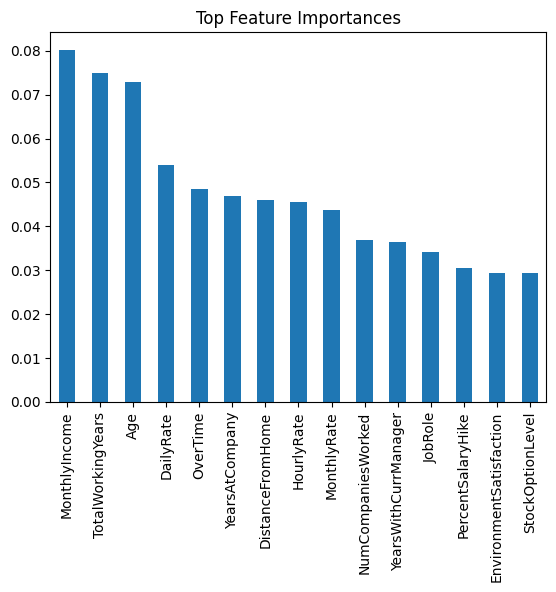

In [24]:

importances = pd.Series(
    model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

importances.head(15).plot(kind="bar")
plt.title("Top Feature Importances")
plt.show()


/tmp/ipython-input-2093196762.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


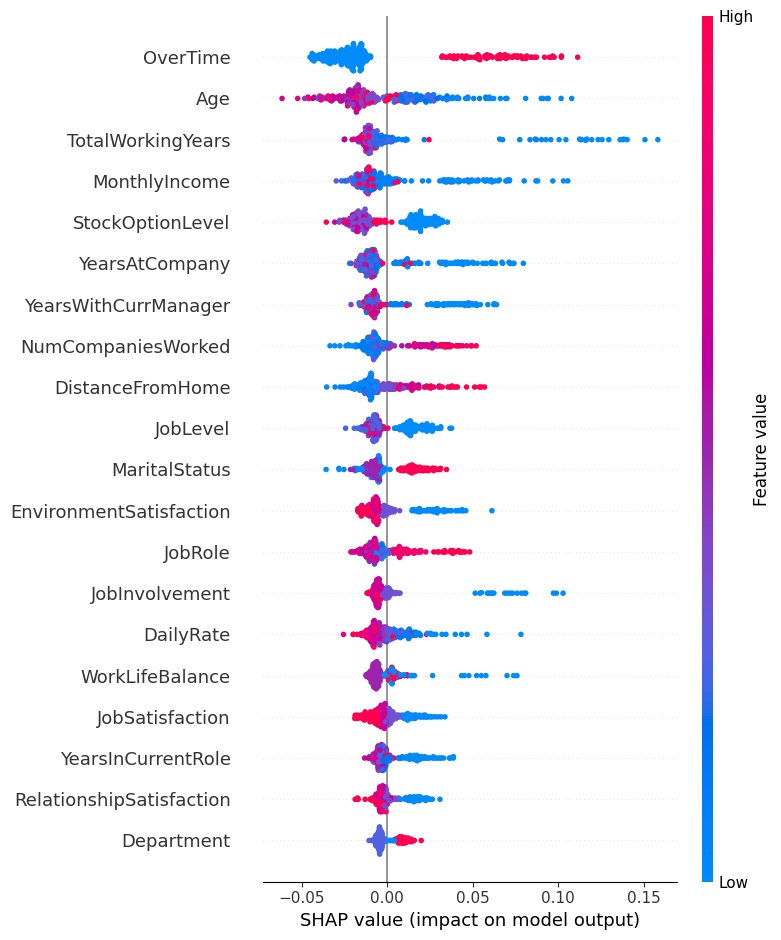

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# NEW SHAP format fix
if isinstance(shap_values, list):
    sv = shap_values[1]
else:
    sv = shap_values[:, :, 1]

shap.summary_plot(
    sv,
    X_test_scaled,
    feature_names=feature_names
)


In [29]:

results = X_test.copy()
results["RiskScore"] = probabilities
results["RiskZone"] = risk_labels

results.sort_values("RiskScore", ascending=False).head(10)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,RiskScore,RiskZone
688,19,2,419,2,21,3,4,4,1,37,...,0,1,3,4,1,0,0,0,0.928553,Very High
911,25,1,599,2,24,1,1,3,1,73,...,0,1,4,3,1,0,1,0,0.806016,Very High
301,18,2,812,2,10,3,3,4,0,69,...,0,0,2,3,0,0,0,0,0.752343,High
711,29,2,906,1,10,3,1,4,0,92,...,0,3,5,3,0,0,0,0,0.673305,High
109,22,2,534,1,15,3,3,2,0,59,...,0,1,5,3,0,0,0,0,0.567726,Medium
1311,18,0,1431,1,14,3,3,2,0,33,...,0,0,4,1,0,0,0,0,0.555964,Medium
476,24,2,823,1,17,2,4,4,1,94,...,1,1,2,3,1,0,0,0,0.534814,Medium
860,22,1,1256,1,3,4,1,3,1,48,...,1,1,5,3,0,0,0,0,0.523962,Medium
17,22,0,1123,1,16,2,3,4,1,96,...,2,1,2,2,1,0,0,0,0.521810,Medium
1061,24,0,830,2,13,2,1,4,0,78,...,1,1,2,3,1,0,0,0,0.509359,Medium
